In [128]:
market_data_folder_1h = cs.market_data_folder_1h
btc_per_portfolio = 100
start_index = 7  # 0, 24, 48, 72, 96; 23 means running at time 00:00

#####################################################
#################### 8h #############################
#####################################################
windows = 8
###########
data_price = {}
for symbol in cs.coin_list:
    if symbol == 'BTC':
        btc_index = pd.read_pickle('{0}/{1}.pkl'.format(market_data_folder_1h, symbol)).index
        data_price[symbol] = pd.read_pickle('{0}/{1}.pkl'.format(market_data_folder_1h, symbol))[['open','high','low','close','amount']]
        data_price[symbol] = data_price[symbol].transform({'open': lambda x: 1/x, 'high': lambda x: 1/x, 'low': lambda x: 1/x, 'close': lambda x: 1/x, 'amount': lambda x:x})
        data_price[symbol] = data_price[symbol].rolling(windows).agg({'open': lambda rows: rows[0], 'high': 'max', 'low': 'min', 'close': lambda rows: rows[-1], 'amount': 'sum'})
        data_price[symbol] = data_price[symbol][start_index:-1:windows]
    else:      
        data_price[symbol] = pd.read_pickle('{0}/{1}.pkl'.format(market_data_folder_1h, symbol))[['open','high','low','close','amount']]
        temp_df = pd.DataFrame(index = btc_index)
        data_price[symbol] = pd.concat([data_price[symbol], temp_df], axis=1)
        data_price[symbol] = data_price[symbol].rolling(windows).agg({'open': lambda rows: rows[0], 'high': 'max', 'low': 'min', 'close': lambda rows: rows[-1], 'amount': 'sum'})
        data_price[symbol] = data_price[symbol][start_index:-1:windows]

# AROON 
#### 该指标是通过计算自价格达到近期最高值和最低值以来所经过的期间数，阿隆指标帮助你预测价格趋势到趋势区域（或者反过来，从趋势区域到趋势）的变化。

In [144]:
def aroon(df, period = 14):
    aroondown, aroonup = ta.AROON(df.high.values, df.low.values,timeperiod=period)
    
    ### signal 1 
    pos = pd.Series(index = df.index)
    pos[ (aroonup > aroondown) & (aroonup > 50)] = 1
    pos[ (pos.shift(1) ==1 ) & ((aroonup < aroondown) | (aroonup < 50))] = 0
    pos[ (aroonup < aroondown) & (aroondown > 50)] = -1
    pos[ (pos.shift(1) == -1 ) & ((aroonup > aroondown) | (aroondown < 50))] = 0
    pos.ffill(inplace = True)

#     ### signal 2 
#     pos = pd.Series(0,index = df.index)
#     pos[ (aroondown < 50) & (aroonup > 50)] = 1
#     pos[ (aroonup < 50) & (aroondown > 50)] = -1
    
    return pos

8h signal, 1h Data:
 index               All     2018     2019     2020     2021
ret_pct         242.39%   228.0%  207.51%  261.87%   652.2%
ret_pct_maxbs    54.85%   49.33%   47.33%   69.48%  280.71%
volat_pct        74.65%   89.33%   64.02%   77.93%  135.01%
sharpe          3.24696  2.55226  3.24133  3.36028  4.83068
tvr             46.1846  24.7955  46.3392  49.2662  57.4884
tvr_rate         10.74%    10.4%   10.69%   10.83%   10.23%
rot_bps         25.7576  25.0357  22.1532  27.5978  72.7906
daily_pnl       2.85505  1.48986  2.46375  3.26313  10.0431
daily_volat      16.799  11.1523  14.5217  18.5527  39.7196
mdd            -173.339 -57.9821 -117.921 -173.339 -136.727
booksize         429.93  238.507  433.361  454.816  562.057
abs_booksize     429.93  238.507  433.361  454.816  562.057
max_booksize       1900  1102.41     1900  1714.13  1305.85
min_booksize          0        0        0        0        0
gini_coef        0.5449   0.6702   0.6588   0.5307        0
gini_negative    0.

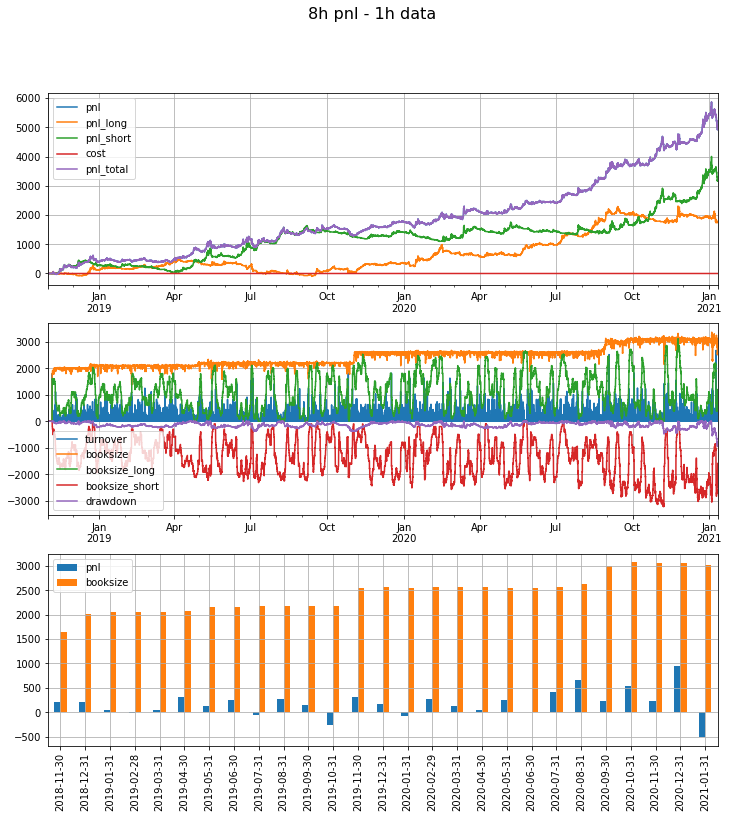

In [145]:
# data_price = swap_price
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    pos = pd.Series(aroon(data, 14), index=data.index)
    pos[pos > 0] = btc_per_portfolio 
    pos[pos < 0] = -btc_per_portfolio
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price_8h = data_price_8h[start_index:-1:windows]
target_portfolio.columns = cs.coin_list
target_portfolio_8h = target_portfolio.copy()


########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_8h_share = target_portfolio_8h / data_price_8h  # combined
target_portfolio_8h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_8h_share = pd.concat([target_portfolio_8h_share, temp_df], axis=1)
target_portfolio_8h_share.ffill(inplace=True)
target_portfolio_8h_share.fillna(0, inplace=True)

aroon_bt_result_8h = bt.backtest(data_price_1h,
                        target_portfolio_8h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
aroon_bt_stats_all_8h = ba.statistics(aroon_bt_result_8h, trading_bars_year=365 * 24)
print('8h signal, 1h Data:\n', bt_stats_all_8h, '\n')
ba.plot_pnl_portfolio(aroon_bt_result_8h, title="8h pnl - 1h data")

# CMO - Chande Momentum Oscillator 钱德动量摆动指标

In [146]:
def cmo(df, period = 14):
    cmo_value = ta.CMO(df.close.values,timeperiod=period)
    
    


    ### signal 1 
    pos = pd.Series(0,index = df.index)
    pos[ (cmo_value > 0) & (cmo_value < 50)] = 1
    pos[ (cmo_value < 0) & (cmo_value > -50)] = -1
    
    
#     ### signal 2 
#     pos = pd.Series(0,index = df.index)
#     pos[ (cmo_value > 0)] = 1
#     pos[ (cmo_value < 0)] = -1
    
    return pos

8h signal, 1h Data:
 index               All     2018     2019     2020     2021
ret_pct         242.39%   228.0%  207.51%  261.87%   652.2%
ret_pct_maxbs    54.85%   49.33%   47.33%   69.48%  280.71%
volat_pct        74.65%   89.33%   64.02%   77.93%  135.01%
sharpe          3.24696  2.55226  3.24133  3.36028  4.83068
tvr             46.1846  24.7955  46.3392  49.2662  57.4884
tvr_rate         10.74%    10.4%   10.69%   10.83%   10.23%
rot_bps         25.7576  25.0357  22.1532  27.5978  72.7906
daily_pnl       2.85505  1.48986  2.46375  3.26313  10.0431
daily_volat      16.799  11.1523  14.5217  18.5527  39.7196
mdd            -173.339 -57.9821 -117.921 -173.339 -136.727
booksize         429.93  238.507  433.361  454.816  562.057
abs_booksize     429.93  238.507  433.361  454.816  562.057
max_booksize       1900  1102.41     1900  1714.13  1305.85
min_booksize          0        0        0        0        0
gini_coef        0.5449   0.6702   0.6588   0.5307        0
gini_negative    0.

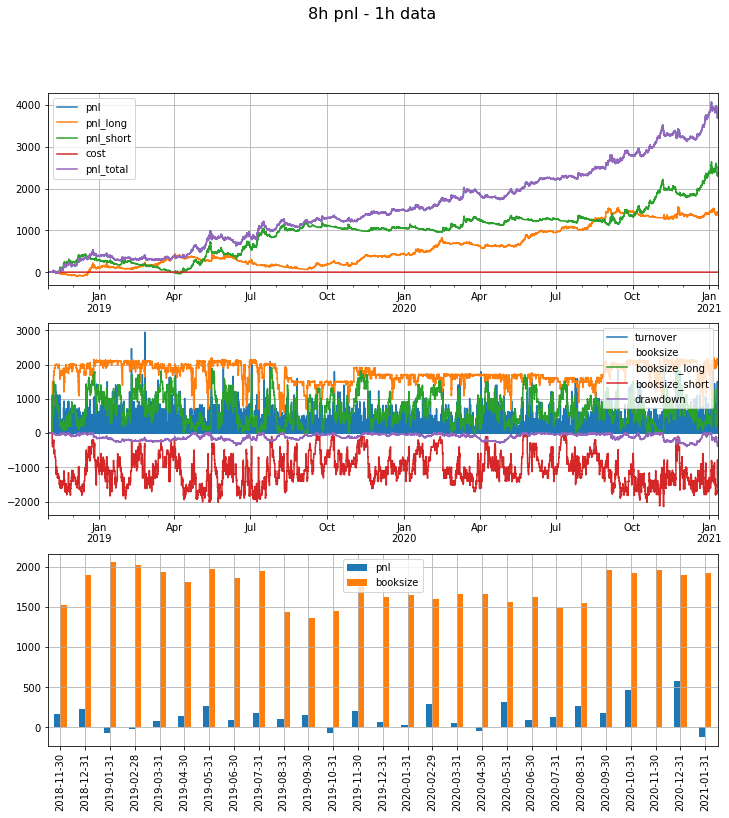

In [147]:
# data_price = swap_price
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    pos = pd.Series(cmo(data, 14), index=data.index)
    pos[pos > 0] = btc_per_portfolio 
    pos[pos < 0] = -btc_per_portfolio
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price_8h = data_price_8h[start_index:-1:windows]
target_portfolio.columns = cs.coin_list
target_portfolio_8h = target_portfolio.copy()


########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_8h_share = target_portfolio_8h / data_price_8h  # combined
target_portfolio_8h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_8h_share = pd.concat([target_portfolio_8h_share, temp_df], axis=1)
target_portfolio_8h_share.ffill(inplace=True)
target_portfolio_8h_share.fillna(0, inplace=True)

cmo_bt_result_8h = bt.backtest(data_price_1h,
                        target_portfolio_8h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
cmo_bt_stats_all_8h = ba.statistics(cmo_bt_result_8h, trading_bars_year=365 * 24)
print('8h signal, 1h Data:\n', bt_stats_all_8h, '\n')
ba.plot_pnl_portfolio(cmo_bt_result_8h, title="8h pnl - 1h data")

# AD - Chaikin A/D Line 量价指标

In [148]:
def ad_line(df, period = 14):
    ad_value = pd.Series(ta.ADOSC(df.high.values,df.low.values,df.close.values,df.amount.values, fastperiod=3*3, slowperiod=10*3),index = df.index)
    ma = df.close.rolling(90*3).mean()


    ### signal 1 
    pos = pd.Series(0,index = df.index)
    pos[ (ad_value.shift(1) < 0) &(ad_value > 0) & (df.close >ma)] = 1
    pos[ (ad_value.shift(1) > 0) &(ad_value < 0) & (df.close <ma)] = -1
    pos[ (pos.shift(1) == 1) & (df.close > ma)] = 1
    pos[ (pos.shift(1) == -1) & (df.close < ma)] = -1
    
    
#     ### signal 2 
#     pos = pd.Series(index = df.index)
#     pos[ (ad_value.shift(1) < 0) &(ad_value > 0) & (df.close >ma)] = 1
#     pos[ (ad_value.shift(1) > 0) &(ad_value < 0) & (df.close <ma)] = -1
#     pos.ffill(inplace = True)

    
    return pos

8h signal, 1h Data:
 index               All     2018     2019     2020     2021
ret_pct         242.39%   228.0%  207.51%  261.87%   652.2%
ret_pct_maxbs    54.85%   49.33%   47.33%   69.48%  280.71%
volat_pct        74.65%   89.33%   64.02%   77.93%  135.01%
sharpe          3.24696  2.55226  3.24133  3.36028  4.83068
tvr             46.1846  24.7955  46.3392  49.2662  57.4884
tvr_rate         10.74%    10.4%   10.69%   10.83%   10.23%
rot_bps         25.7576  25.0357  22.1532  27.5978  72.7906
daily_pnl       2.85505  1.48986  2.46375  3.26313  10.0431
daily_volat      16.799  11.1523  14.5217  18.5527  39.7196
mdd            -173.339 -57.9821 -117.921 -173.339 -136.727
booksize         429.93  238.507  433.361  454.816  562.057
abs_booksize     429.93  238.507  433.361  454.816  562.057
max_booksize       1900  1102.41     1900  1714.13  1305.85
min_booksize          0        0        0        0        0
gini_coef        0.5449   0.6702   0.6588   0.5307        0
gini_negative    0.

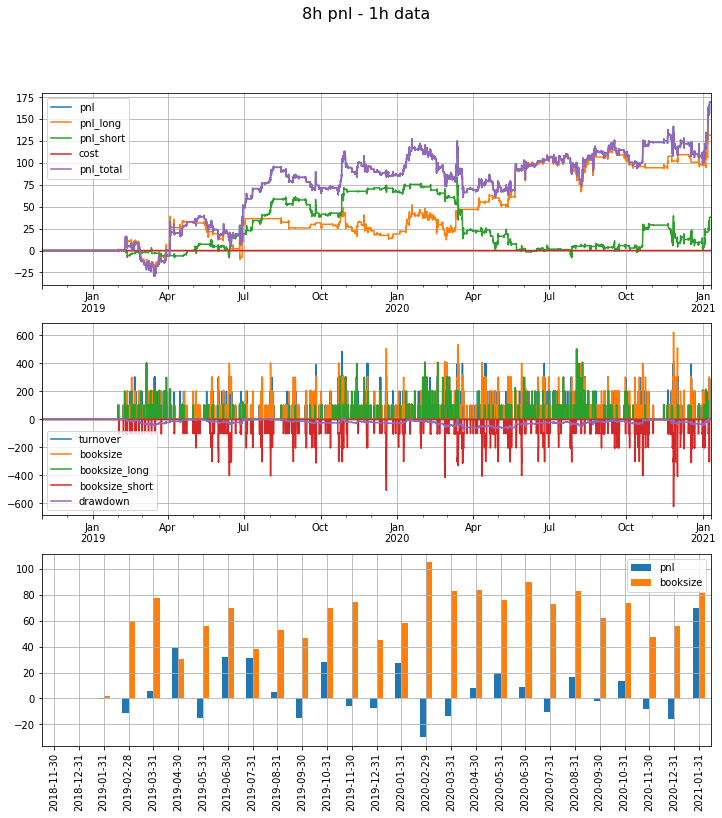

In [149]:
# data_price = swap_price
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    pos = pd.Series(ad_line(data, 14), index=data.index)
    pos[pos > 0] = btc_per_portfolio 
    pos[pos < 0] = -btc_per_portfolio
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price_8h = data_price_8h[start_index:-1:windows]
target_portfolio.columns = cs.coin_list
target_portfolio_8h = target_portfolio.copy()


########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_8h_share = target_portfolio_8h / data_price_8h  # combined
target_portfolio_8h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_8h_share = pd.concat([target_portfolio_8h_share, temp_df], axis=1)
target_portfolio_8h_share.ffill(inplace=True)
target_portfolio_8h_share.fillna(0, inplace=True)

ad_line_bt_result_8h = bt.backtest(data_price_1h,
                        target_portfolio_8h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
ad_line_bt_stats_all_8h = ba.statistics(ad_line_bt_result_8h, trading_bars_year=365 * 24)
print('8h signal, 1h Data:\n', bt_stats_all_8h, '\n')
ba.plot_pnl_portfolio(ad_line_bt_result_8h, title="8h pnl - 1h data")

# Commodity Channel Index 顺势指标

In [150]:
def cci(df, period = 14):
    cci_value = pd.Series(ta.CCI(df.high.values,df.low.values,df.close.values,timeperiod = period),index = df.index)



    ### signal 1 
    pos = pd.Series(index = df.index)
    pos[ (cci_value.shift(1) < 100) &(cci_value > 100)] = 1
    pos[ (cci_value.shift(1) > -100) &(cci_value < -100)] = -1    
    pos.ffill(inplace = True)
    
#     ### signal 2 
#     pos = pd.Series(0,index = df.index)
#     pos[ (cci_value.shift(1) < 100) &(cci_value > 100)] = 1
#     pos[ (cci_value.shift(1) > -100) &(cci_value < -100)] = -1  
#     pos[ (pos.shift(1) == 1) &(cci_value >100)] = 1    
#     pos[ (pos.shift(1) == -1) &(cci_value < -100)] = -1  
#     pos.ffill(inplace = True)

    
    return pos

8h signal, 1h Data:
 index               All     2018     2019     2020     2021
ret_pct         242.39%   228.0%  207.51%  261.87%   652.2%
ret_pct_maxbs    54.85%   49.33%   47.33%   69.48%  280.71%
volat_pct        74.65%   89.33%   64.02%   77.93%  135.01%
sharpe          3.24696  2.55226  3.24133  3.36028  4.83068
tvr             46.1846  24.7955  46.3392  49.2662  57.4884
tvr_rate         10.74%    10.4%   10.69%   10.83%   10.23%
rot_bps         25.7576  25.0357  22.1532  27.5978  72.7906
daily_pnl       2.85505  1.48986  2.46375  3.26313  10.0431
daily_volat      16.799  11.1523  14.5217  18.5527  39.7196
mdd            -173.339 -57.9821 -117.921 -173.339 -136.727
booksize         429.93  238.507  433.361  454.816  562.057
abs_booksize     429.93  238.507  433.361  454.816  562.057
max_booksize       1900  1102.41     1900  1714.13  1305.85
min_booksize          0        0        0        0        0
gini_coef        0.5449   0.6702   0.6588   0.5307        0
gini_negative    0.

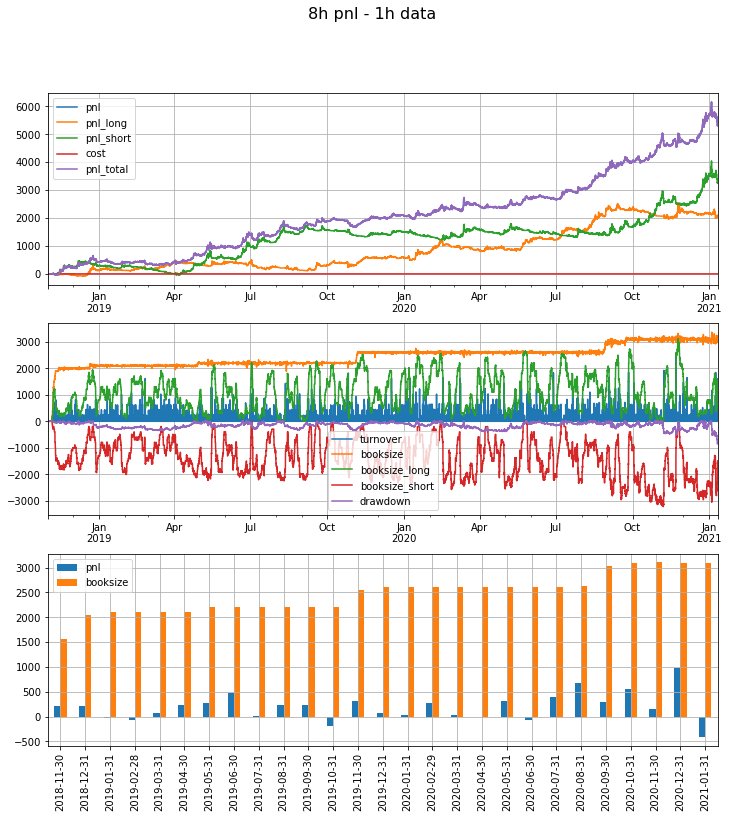

In [151]:
# data_price = swap_price
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    pos = pd.Series(cci(data, 14), index=data.index)
    pos[pos > 0] = btc_per_portfolio 
    pos[pos < 0] = -btc_per_portfolio
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price_8h = data_price_8h[start_index:-1:windows]
target_portfolio.columns = cs.coin_list
target_portfolio_8h = target_portfolio.copy()


########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_8h_share = target_portfolio_8h / data_price_8h  # combined
target_portfolio_8h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_8h_share = pd.concat([target_portfolio_8h_share, temp_df], axis=1)
target_portfolio_8h_share.ffill(inplace=True)
target_portfolio_8h_share.fillna(0, inplace=True)

cci_bt_result_8h = bt.backtest(data_price_1h,
                        target_portfolio_8h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
cci_bt_stats_all_8h = ba.statistics(cci_bt_result_8h, trading_bars_year=365 * 24)
print('8h signal, 1h Data:\n', bt_stats_all_8h, '\n')
ba.plot_pnl_portfolio(cci_bt_result_8h, title="8h pnl - 1h data")

# Pattern Recognition Functions 形态识别

In [152]:
# CDL2CROWS - Two Crows
# 三日K线模式，第一天长阳，第二天高开收阴，第三天再次高开继续收阴， 收盘比前一日收盘价低，预示股价下跌。
def down_01(df):
    
    return pd.Series(ta.CDL2CROWS(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def down_02(df):
    
    return pd.Series(ta.CDL3BLACKCROWS(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def down_03(df):
    
    return pd.Series(ta.CDL3LINESTRIKE(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def down_04(df):
    
    return pd.Series(ta.CDLDARKCLOUDCOVER(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def down_05(df):
    
    return pd.Series(ta.CDLSHOOTINGSTAR(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)

In [153]:
def up_01(df):
    
    return pd.Series(ta.CDL3INSIDE(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def up_02(df):
    
    return pd.Series(ta.CDL3OUTSIDE(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def up_03(df):
    
    return pd.Series(ta.CDL3STARSINSOUTH(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def up_04(df):
    
    return pd.Series(ta.CDL3WHITESOLDIERS(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def up_05(df):
    
    return pd.Series(ta.CDLBELTHOLD(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def up_06(df):
    
    return pd.Series(ta.CDLBREAKAWAY(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def up_07(df):
    
    return pd.Series(ta.CDLRISEFALL3METHODS(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def up_08(df):
    
    return pd.Series(ta.CDLXSIDEGAP3METHODS(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)

In [154]:
def reverse_01(df):
    
    return pd.Series(ta.CDLABANDONEDBABY(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def reverse_02(df):
    
    return pd.Series(ta.CDLDOJISTAR(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def reverse_03(df):
    
    return pd.Series(ta.CDLDRAGONFLYDOJI(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def reverse_04(df):
    
    return pd.Series(ta.CDLHARAMICROSS(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)
def reverse_05(df):
    
    return pd.Series(ta.CDLHOMINGPIGEON(df.open.values,df.high.values,df.low.values,df.close.values),index = df.index)

In [155]:
def pattern(df):
       
    
#     ### signal 1 (sharpe = 2.5)
#     pos = pd.Series(0,index = df.index)
#     up = up_01(df)+up_02(df)+up_03(df)+up_04(df)+up_05(df)+up_06(df)+up_07(df)
#     down = down_01(df)+down_02(df)+down_03(df)+down_04(df)+down_05(df)
#     pos[ (up > 0) ] = 1
#     pos[ (down > 0) ] = -1
#     pos[ (up < 0) ] = -1
#     pos[ (down > 0) ] = 1
#     pos[(pos.shift(1) != 0) & (pos == 0) ] = pos.shift(1)  

    ### signal 2 (sharpe = )
    ma = df.close.rolling(90).mean() 
    pos = pd.Series(0,index = df.index)
    up = up_01(df)+up_02(df)+up_03(df)+up_04(df)+up_05(df)+up_06(df)+up_07(df)
    down = down_01(df)+down_02(df)+down_03(df)+down_04(df)+down_05(df)
    pos[ (up > 0) &(df.close> ma) ] = 1
    pos[ (down > 0) &(df.close < ma)] = -1
    pos[ (up < 0)&(df.close < ma) ] = -1
    pos[ (down > 0)&(df.close > ma) ] = 1
    pos[(pos.shift(1) != 0) & (pos == 0) ] = pos.shift(1)  

    return pos

8h signal, 1h Data:
 index               All     2018     2019     2020     2021
ret_pct         242.39%   228.0%  207.51%  261.87%   652.2%
ret_pct_maxbs    54.85%   49.33%   47.33%   69.48%  280.71%
volat_pct        74.65%   89.33%   64.02%   77.93%  135.01%
sharpe          3.24696  2.55226  3.24133  3.36028  4.83068
tvr             46.1846  24.7955  46.3392  49.2662  57.4884
tvr_rate         10.74%    10.4%   10.69%   10.83%   10.23%
rot_bps         25.7576  25.0357  22.1532  27.5978  72.7906
daily_pnl       2.85505  1.48986  2.46375  3.26313  10.0431
daily_volat      16.799  11.1523  14.5217  18.5527  39.7196
mdd            -173.339 -57.9821 -117.921 -173.339 -136.727
booksize         429.93  238.507  433.361  454.816  562.057
abs_booksize     429.93  238.507  433.361  454.816  562.057
max_booksize       1900  1102.41     1900  1714.13  1305.85
min_booksize          0        0        0        0        0
gini_coef        0.5449   0.6702   0.6588   0.5307        0
gini_negative    0.

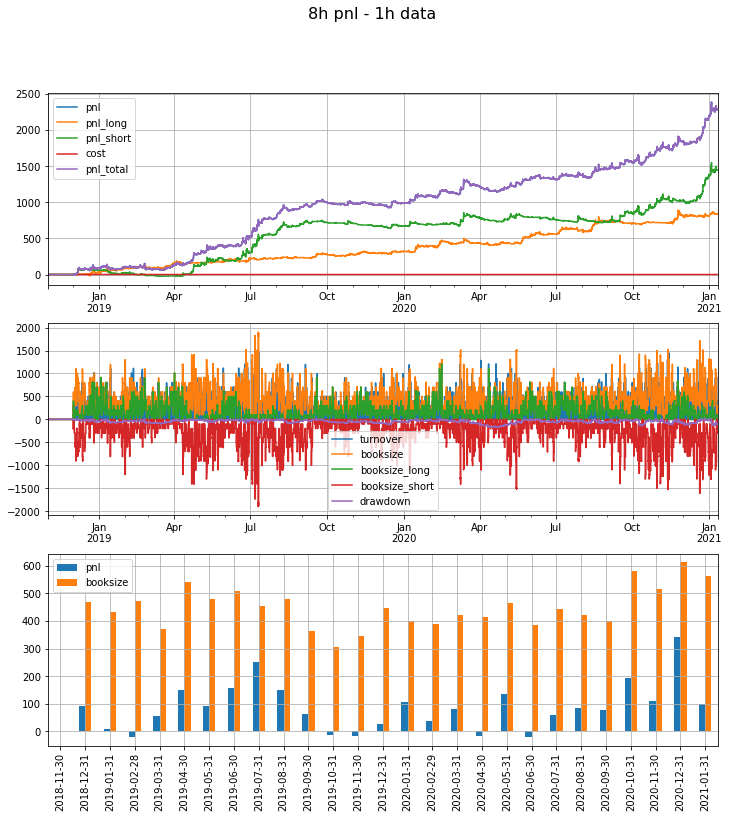

In [156]:
# data_price = swap_price
target_portfolio = pd.DataFrame()
for coin in cs.coin_list:
    data = data_price[coin]
    pos = pd.Series(pattern(data), index=data.index)
    pos[pos > 0] = btc_per_portfolio 
    pos[pos < 0] = -btc_per_portfolio
    target_portfolio = pd.concat([target_portfolio, pos], axis=1)

data_price_8h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
data_price_8h = data_price_8h[start_index:-1:windows]
target_portfolio.columns = cs.coin_list
target_portfolio_8h = target_portfolio.copy()


########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_8h_share = target_portfolio_8h / data_price_8h  # combined
target_portfolio_8h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_8h_share = pd.concat([target_portfolio_8h_share, temp_df], axis=1)
target_portfolio_8h_share.ffill(inplace=True)
target_portfolio_8h_share.fillna(0, inplace=True)
pattern_bt_result_8h = bt.backtest(data_price_1h,
                        target_portfolio_8h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
pattern_bt_stats_all_8h = ba.statistics(pattern_bt_result_8h, trading_bars_year=365 * 24)
print('8h signal, 1h Data:\n', bt_stats_all_8h, '\n')
ba.plot_pnl_portfolio(pattern_bt_result_8h, title="8h pnl - 1h data")

# CORR

In [142]:
btc_pnl = pd.read_csv("...._pnl.csv")

In [164]:
corr_df = pd.DataFrame()
corr_df['cta'] = btc_pnl['pnl_total'].values
corr_df['cmo'] = cmo_bt_result_8h['pnl_total'].values
corr_df['aroon'] = aroon_bt_result_8h['pnl_total'].values
corr_df['ad_line'] = ad_line_bt_result_8h['pnl_total'].values
corr_df['cci'] = cci_bt_result_8h['pnl_total'].values
corr_df['pattern'] = pattern_bt_result_8h['pnl_total'].values
corr_df.corr()

,cta,cmo,aroon,ad_line,cci,pattern
cta,1.000000,0.629138,0.684248,0.183693,0.714938,0.575048
cmo,0.629138,1.000000,0.739081,0.187495,0.799024,0.545473
aroon,0.684248,0.739081,1.000000,0.144820,0.938815,0.508251
ad_line,0.183693,0.187495,0.144820,1.000000,0.167498,0.227332
cci,0.714938,0.799024,0.938815,0.167498,1.000000,0.550329
pattern,0.575048,0.545473,0.508251,0.227332,0.550329,1.000000


In [161]:
RESULT_df = pd.DataFrame()
RESULT_df['cmo'] = cmo_bt_stats_all_8h['All']
RESULT_df['aroon'] = aroon_bt_stats_all_8h['All']
RESULT_df['ad_line'] = ad_line_bt_stats_all_8h['All']
RESULT_df['cci'] = cci_bt_stats_all_8h['All']
RESULT_df['pattern'] = pattern_bt_stats_all_8h['All']

In [163]:
RESULT_df.to_csv("other_signal_btc.csv")

In [167]:
corr_df.corr().to_csv("CORR_BTC.csv")